In [14]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()
%matplotlib inline

In [15]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

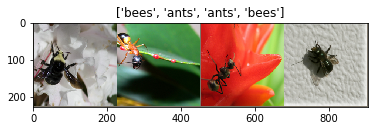

In [16]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dset_loaders['train']))


out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dset_classes[x] for x in classes])
use_gpu = torch.cuda.is_available()

In [17]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

In [18]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [19]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1580 Acc: 0.6844
val Loss: 0.0706 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.1840 Acc: 0.7418
val Loss: 0.0601 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.0927 Acc: 0.8566
val Loss: 0.0596 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.1135 Acc: 0.8361
val Loss: 0.0550 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.1302 Acc: 0.8197
val Loss: 0.0748 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.1253 Acc: 0.7910
val Loss: 0.0512 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.1684 Acc: 0.8033
val Loss: 0.0570 Acc: 0.9150

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0963 Acc: 0.8443
val Loss: 0.0578 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.0905 Acc: 0.8443
val Loss: 0.0743 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.0932 Acc: 0.8238
val Loss: 0.0477 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.0880 Acc: 0.8689
val Loss: 0.0540 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0785 Acc: 

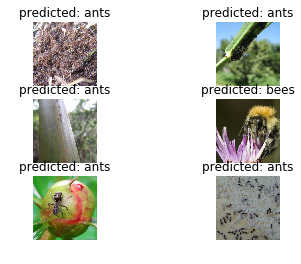

In [22]:
visualize_model(model_ft)

In [23]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1379 Acc: 0.6967
val Loss: 0.0671 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.1553 Acc: 0.7336
val Loss: 0.0469 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.1321 Acc: 0.7623
val Loss: 0.0414 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.1372 Acc: 0.7582
val Loss: 0.0524 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.0874 Acc: 0.8402
val Loss: 0.0396 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.1116 Acc: 0.8156
val Loss: 0.0398 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.1725 Acc: 0.7131
val Loss: 0.0550 Acc: 0.9281

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.1034 Acc: 0.8074
val Loss: 0.0473 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.0849 Acc: 0.8525
val Loss: 0.0501 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.0741 Acc: 0.8852
val Loss: 0.0459 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.1000 Acc: 0.8156
val Loss: 0.0483 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0801 Acc: 

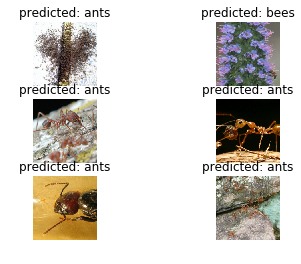

In [25]:
visualize_model(model_conv)

plt.ioff()
plt.show()